In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import json

In [31]:
def plot_graph(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string], '')
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()

In [32]:
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'
TRAIN_INPUT_DATA ='train_input.npy'
TRAIN_LABEL_DATA ='train_label.npy'
DATA_CONFIGS = 'data_configs.json'

In [33]:
train_input = np.load(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'rb'))
train_label = np.load(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))
                                

In [34]:
print(train_input.shape)
print(train_label.shape)

(25000, 174)
(25000,)


In [36]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

model_name = 'rnn_classifier_en'
BATCH_SIZE = 128
NUM_EPOCHS = 5
VALID_SPLIT = 0.1
MAX_LEN = train_input.shape[1]

kargs = {'model_name':model_name,
         'vocab_size':prepro_configs['vocab_size'],
         'embedding_dimension':100,
         'dropout_rate': 0.2,
         'lstm_dimension': 150,
         'dense_dimension': 150,
         'output_dimension':1}      

### 모델 선언
- LSTM 각 단계에서 현재 정보는 input state, 이전 정보는 hidden state 라 함  
- LSTM 의 매개변수 중 return_sequences 은 hidden state 의 반환값을 결정하는데  
- false 일 경우 predict 시 마지막 hidden state만 출력됨  
- true 일 경우 각 time step 별 모든 hidden state 를 출력함  
- 이전의 기록들이 다음 레이어로 들어가기 때문에 LSTM레이어끼리 엮기 위해서는 return_sequence를 사용하여야 함 

In [37]:
class RNNClassifier(tf.keras.Model):
    def __init__(self, **kargs):#딕셔너리를 받을때는 **개
        super(RNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'] + 1,
                                          output_dim=kargs['embedding_dimension'])
        
        self.lstm_1_layer = layers.LSTM(kargs['lstm_dimension'],
                                       return_sequences=True)
        self.lstm_2_layer = layers.LSTM(kargs['lstm_dimension'])
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(kargs['dense_dimension'], activation= tf.keras.activations.tanh)
        self.fc2 = layers.Dense(kargs['output_dimension'], activation= tf.keras.activations.sigmoid)
    
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = self.lstm_1_layer(x)
        x = self.lstm_2_layer(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x
        

In [38]:
model = RNNClassifier(**kargs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss= tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

In [39]:
earlystop_callback = EarlyStopping(monitor='val_accuacy', min_delta=0.0001, patience=3)
checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)
if os.path.exists(checkpoint_dir):
    print('{} -- Folder already exists \n'.format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok =True)
    print('{} -- Folder create complete \n'.format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1,
                              save_bset_only=True, save_weights_only=True)


./data_out/rnn_classifier_en -- Folder already exists 



In [40]:
history = model.fit(train_input,train_label, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=VALID_SPLIT,
                    callbacks=[earlystop_callback, cp_callback])

Epoch 1/5
176/176 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5070WARNING:tensorflow:Early stopping conditioned on metric `val_accuacy` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy

Epoch 00001: saving model to ./data_out/rnn_classifier_en\weights.h5
176/176 [==============================] - 242s 1s/step - loss: 0.6931 - accuracy: 0.5070 - val_loss: 0.6929 - val_accuracy: 0.5096
Epoch 2/5
176/176 [==============================] - ETA: 0s - loss: 0.6914 - accuracy: 0.5135WARNING:tensorflow:Early stopping conditioned on metric `val_accuacy` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy

Epoch 00002: saving model to ./data_out/rnn_classifier_en\weights.h5
176/176 [==============================] - 185s 1s/step - loss: 0.6914 - accuracy: 0.5135 - val_loss: 0.6887 - val_accuracy: 0.5020
Epoch 3/5
176/176 [==============================] - ETA: 0s - loss: 0.4618 - accuracy: 0.7787WARNING:

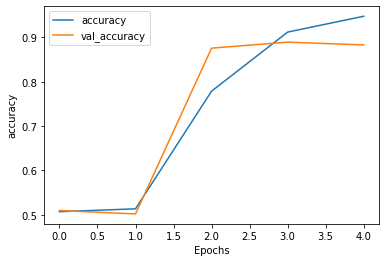

In [41]:
plot_graph(history, 'accuracy')

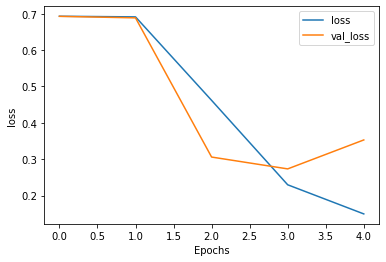

In [42]:
plot_graph(history, 'loss')

In [43]:
TEST_INPUT_DATA = 'test_input.npy'
TEST_ID_DATA = 'test_id.npy'

test_input = np.load(open(DATA_IN_PATH + TEST_INPUT_DATA, 'rb'))
test_input = pad_sequences(test_input, maxlen=test_input.shape[1])

In [45]:
SAVE_FILE_NM = 'weights.h5'
model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))


In [47]:
predictions = model.predict(test_input, batch_size=BATCH_SIZE)
predictions = predictions.squeeze(-1)

In [48]:
print(predictions[:10])

[0.9975365  0.00160778 0.6304182  0.31067905 0.98849297 0.99030834
 0.00219923 0.4333138  0.00113937 0.03225255]


In [50]:
import pandas as pd

test_id = np.load(open(DATA_IN_PATH + TEST_ID_DATA, 'rb'),allow_pickle=True)
#allow_pickle=True 판다스 시리즈객체이므로 객체로 읽을때는 설정해줘야한다

if not os.path.exists(DATA_OUT_PATH):
    os.makedirs(DATA_OUT_PATH)
    
output = pd.DataFrame({'id': list(test_id), 'sentiment': list(predictions)})
output.head()

,id,sentiment
0,"""12311_10""",0.997536
1,"""8348_2""",0.001608
2,"""5828_4""",0.630418
3,"""7186_2""",0.310679
4,"""12128_7""",0.988493


In [51]:
output.to_csv(DATA_OUT_PATH + 'review_result_rnn.csv',index=False, quoting=3)

In [52]:
model.summary()

Model: "rnn_classifier_en"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      multiple                  7720000   
_________________________________________________________________
lstm_10 (LSTM)               multiple                  150600    
_________________________________________________________________
lstm_11 (LSTM)               multiple                  180600    
_________________________________________________________________
dropout_4 (Dropout)          multiple                  0         
_________________________________________________________________
dense_6 (Dense)              multiple                  22650     
_________________________________________________________________
dense_7 (Dense)              multiple                  151       
Total params: 8,074,001
Trainable params: 8,074,001
Non-trainable params: 0
_______________________________________